# Data Preprocessing
### Prepared by: <a href="https://www.linkedin.com/in/a-kanaan/">Dr Abdulkarim M. Jamal Kanaan</a>
<hr>

* Acknowledgements: I would like to acknowledge the book "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" written by Aurélien Géron. This practical exercise was heavily influenced by Chapter 2 of the book, titled "End-to-End Machine Learning Project."

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/a-kanaan/dm-practicals/blob/main/practical4/practical4_data-preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

Here are the some of the steps for data preprocessing:

* Work on copies of the data to preserve the original dataset.
1. Data cleaning:
   - Address or remove outliers (if necessary).
   - Fill in missing values (e.g., with zero, mean, median) or drop corresponding rows/columns.
2. Optional: Perform feature selection.
   - Eliminate attributes that do not contribute useful information to the task.
3. Perform feature engineering when applicable.
   - Convert continuous features into discrete ones if suitable.
   - Apply relevant transformations to features (e.g., log(x), sqrt(x), x^2, etc.).
   - Combine features to create new and promising attributes.
4. Apply feature scaling to ensure consistent scales:
   - Standardize or normalize the features as needed.
   
adapted from: https://github.com/ageron/handson-ml3/blob/main/ml-project-checklist.md

## Loading the dataset

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import sklearn
sklearn.set_config(display="diagram")

In [3]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
from sklearn.model_selection import train_test_split


train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

print("Length of train_set:", len(train_set))
print("Length of test_set:", len(test_set))

Length of train_set: 16512
Length of test_set: 4128


## Experiment with Attribute Combinations (data exploration)

Before preparing the data for machine learning algorithms, it is advisable to experiment with different attribute combinations. For instance, solely considering the total number of rooms in a district might not provide much insight unless you know the corresponding number of households. Therefore, it would be more meaningful to calculate the number of rooms per household. Likewise, solely examining the total number of bedrooms might not be very informative; it is more useful to compare it to the number of rooms. Additionally, considering the population per household could also yield valuable attribute combinations worth exploring.

In [5]:
train_set["rooms_per_house"] = train_set["total_rooms"] / train_set["households"]
train_set["bedrooms_ratio"] = train_set["total_bedrooms"] / train_set["total_rooms"]
train_set["people_per_house"] = train_set["population"] / train_set["households"]

In [6]:
# Afterwards, it is recommended to revisit the correlation matrix analysis:
corr_matrix = train_set.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687013
rooms_per_house       0.146940
total_rooms           0.134060
housing_median_age    0.104714
households            0.065798
total_bedrooms        0.049993
people_per_house     -0.021577
population           -0.025820
longitude            -0.043603
latitude             -0.146324
bedrooms_ratio       -0.254817
Name: median_house_value, dtype: float64

Impressively, the newly created attribute, "bedrooms_ratio," exhibits a higher correlation with the median house value compared to the total number of rooms or bedrooms. Evidently, houses with a lower bedroom/room ratio tend to command higher prices. Furthermore, the number of rooms per household proves to be more informative than the total number of rooms in a district. This observation aligns with the understanding that larger houses tend to be more expensive.

## Prepare the Data for Machine Learning Algorithms

It is advisable to distinguish between the predictors and the labels in order to apply separate transformations to each. This is because the transformations applied to the predictors may not be applicable or desired for the target values. It's important to note that when using the `drop()` function, it creates a copy of the data and does not modify the original `train_set`.

In [7]:
housing = train_set.drop("median_house_value", axis=1) #input features
housing_labels = train_set["median_house_value"].copy() #target variable (output variable/dependent variable)

## Data Cleaning

Majority of machine learning algorithms are unable to handle missing features, so it is necessary to address this issue. For instance, you have observed that the `total_bedrooms` attribute contains some missing values. There are three potential approaches to resolve this problem:

1. Eliminate the districts with missing values. (row/records)
2. Eliminate the entire attribute.
3. Assign a specific value (such as zero, mean, median, etc.) to the missing values. This process is known as imputation.

To carry out these actions efficiently, you can utilize Pandas DataFrame's `dropna()`, `drop()`, and `fillna()` methods.

In [8]:
housing.dropna(subset=["total_bedrooms"], inplace=True) # option 1
housing.drop(labels=["total_bedrooms"], axis=1) # option 2
median = housing["total_bedrooms"].median() # option 3
housing["total_bedrooms"].fillna(median, inplace=True)

You opt for option 3 as it is the least disruptive approach. However, instead of the previous code, you will utilize a convenient class from Scikit-Learn called `SimpleImputer`. The advantage of using this class is that it will retain the median value of each feature. This allows you to impute missing values not only in the training set but also in the validation set, test set, and any future data provided to the model. To employ `SimpleImputer`, you need to create an instance of the class and specify that you want to replace missing values in each attribute with the median value.

In [9]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

As the median can only be calculated for numerical attributes, you will need to create a copy of the data that includes only the numerical attributes. This copy will exclude the text attribute "ocean_proximity."

In [10]:
import numpy as np
housing_num = housing.select_dtypes(include=[np.number]) #use for training
imputer.fit(housing_num)

SimpleImputer(strategy='median')

The imputer has computed the median of each attribute and stored the results in its `statistics_` instance variable. Although only the `total_bedrooms` attribute had missing values in the current data, it is important to consider the possibility of encountering missing values in new data once the system is deployed. Therefore, to ensure completeness and accuracy, it is recommended to apply the imputer to all the numerical attributes in the dataset.

In [11]:
print(imputer.statistics_)
print(housing_num.median().values)

[-1.18490000e+02  3.42500000e+01  2.90000000e+01  2.13000000e+03
  4.37000000e+02  1.17000000e+03  4.11000000e+02  3.52680000e+00
  5.23441397e+00  2.03058929e-01  2.81840796e+00]
[-1.18490000e+02  3.42500000e+01  2.90000000e+01  2.13000000e+03
  4.37000000e+02  1.17000000e+03  4.11000000e+02  3.52680000e+00
  5.23441397e+00  2.03058929e-01  2.81840796e+00]


Now you can use this “trained” imputer to transform the training set by replacing
missing values with the learned medians:

In [12]:
#housing[]
X = imputer.transform(housing_num)

<i>Note: Alternatively, missing values can be replaced using different strategies. For example, you can choose to replace missing values with the mean value (using `strategy="mean"`), the most frequent value (using `strategy="most_frequent"`), or a constant value (using `strategy="constant"` and specifying `fill_value`). The latter two strategies support non-numerical data, providing flexibility in handling missing values for both numerical and non-numerical attributes.</i>

When using Scikit-Learn transformers, such as the `Imputer` class, the output is typically in the form of NumPy arrays or sparse matrices, even if Pandas DataFrames are used as input. As a result, the output of `imputer.transform(housing_num)` will be a NumPy array (`X`) without column names or an index. However, it is possible to wrap `X` in a DataFrame and retrieve the column names and index from `housing_num`.

In [13]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_house,bedrooms_ratio,people_per_house
14196,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878,5.597948,0.185136,2.475746
8267,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648,5.395210,0.180910,4.179641
17445,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875,4.655660,0.224924,2.004043
14265,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663,6.186154,0.157672,3.350769
2271,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688,10.000000,0.191667,2.625000


## Feature Encoding: Handling Text and Categorical Attributes
Up until now, our focus has been solely on numerical attributes. However, it's important to note that your data may also include text attributes. In this particular dataset, there is one such attribute: "ocean_proximity."

In [14]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
14196,NEAR OCEAN
8267,NEAR OCEAN
17445,NEAR BAY
14265,<1H OCEAN
2271,INLAND
17848,NEAR BAY
6252,INLAND
9389,<1H OCEAN


The "ocean_proximity" attribute in the dataset does not consist of arbitrary text but instead has a finite number of distinct values, each representing a specific category. As a result, this attribute is considered categorical. Since most machine learning algorithms operate more effectively with numerical data, it is necessary to convert these categories from text to numerical representation. To accomplish this, we can utilize Scikit-Learn's `OrdinalEncoder` and `OneHotEncoder` classes.

### Ordinal Features
The OrdinalEncoder is typically used when you have categorical features with an inherent order or hierarchy. It is suitable for encoding categorical variables where the relative ordering between categories holds significance.

In [15]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

ordinal_encoder.fit(housing_cat)
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

# OR OR OR OR OR
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

housing_cat_encoded

array([[4.],
       [4.],
       [3.],
       ...,
       [1.],
       [1.],
       [0.]])

The list of categories for categorical attributes can be obtained using the `categories_` instance variable. This variable contains a 1D array or list of categories for each categorical attribute.

In [16]:
housing["ocean_proximity"].unique()

array(['NEAR OCEAN', 'NEAR BAY', '<1H OCEAN', 'INLAND', 'ISLAND'],
      dtype=object)

In [17]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Nominal Features
The OneHotEncoder is used when you have categorical features that do not have a natural ordering or hierarchy. It is suitable for encoding categorical variables where there is no inherent order or relationship between the categories.

In [18]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16349x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16349 stored elements in Compressed Sparse Row format>

A sparse matrix is an efficient way to represent matrices that primarily consist of zeros. It stores only the nonzero values and their positions internally, resulting in significant space savings. While you can utilize a sparse matrix similar to a standard 2D array, if you wish to convert it to a _dense_ NumPy array, you can simply use the `toarray()` method.

In [19]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

Similar to the `OrdinalEncoder`, you can obtain the list of categories by accessing the `categories_` instance variable of the encoder.

In [20]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

When fitting a Scikit-Learn estimator with a DataFrame, the estimator saves the column names in the `feature_names_in_` attribute. Subsequently, Scikit-Learn guarantees that any DataFrame passed to the estimator (e.g., for `transform()` or `predict()`) must have the same column names. Transformers also offer a `get_feature_names_out()` method that can be used to construct a DataFrame based on the transformer's output.

In [21]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [22]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

## Feature Scaling and Transformation
One crucial transformation that should be applied to the data is feature scaling. In general, machine learning algorithms do not perform optimally when the input numerical attributes have significantly different scales. This is evident in the housing data, where the range of total number of rooms is approximately 6 to 39,320, while the range of median incomes only spans from 0 to 15. Without proper scaling, many models will exhibit a bias towards ignoring the median income and placing greater emphasis on the number of rooms.
To ensure that all attributes have a consistent scale, there are two commonly used techniques: `min-max scaling` and `standardization`.

Min-max scaling is a simple technique where the values of each attribute are shifted and rescaled to fall within the range of 0 to 1. This is achieved by subtracting the minimum value and dividing by the difference between the minimum and maximum values of the attribute. In Scikit-Learn, you can utilize the `MinMaxScaler` transformer for this purpose. It provides a `feature_range` hyperparameter that allows you to customize the range if desired. For instance, if zero-mean inputs are preferred, you can set a range of -1 to 1. The `MinMaxScaler` is straightforward to use.

In [23]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)
housing_num_min_max_scaled

array([[ 0.42031873, -0.95536663,  0.29411765, ..., -0.93321441,
        -0.81080931, -0.9971296 ],
       [ 0.45816733, -0.96811902, -0.64705882, ..., -0.93608971,
        -0.82019978, -0.99438722],
       [-0.58565737,  0.10520723,  0.05882353, ..., -0.94657827,
        -0.72239108, -0.99788879],
       ...,
       [ 0.        , -0.20510096, -0.41176471, ..., -0.94104015,
        -0.77591463, -0.99778078],
       [ 0.42629482, -0.67268863, -0.17647059, ..., -0.94178085,
        -0.72228978, -0.99600889],
       [ 0.0936255 , -0.64293305, -0.17647059, ..., -0.92314855,
        -0.86088528, -0.9955595 ]])

Standardization operates differently from min-max scaling. It involves two steps: first, subtracting the mean value from each data point (resulting in standardized values with a zero mean), and then dividing the result by the standard deviation (yielding standardized values with a standard deviation of 1). Unlike min-max scaling, standardization does not confine values to a specific range. However, standardization is less susceptible to the influence of outliers compared to min-max scaling.

In [24]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)
housing_num_std_scaled

array([[ 1.17326778, -1.35034078,  0.42934493, ...,  0.06306804,
        -0.4854111 , -0.05346344],
       [ 1.2683057 , -1.37845247, -1.4716757 , ..., -0.01586241,
        -0.55898986,  0.09295025],
       [-1.35274028,  0.98761451, -0.04591023, ..., -0.30378527,
         0.20738752, -0.09399635],
       ...,
       [ 0.11784659,  0.30356346, -0.99642054, ..., -0.15175753,
        -0.21199481, -0.0882296 ],
       [ 1.18827377, -0.72719839, -0.52116538, ..., -0.17209055,
         0.20818128,  0.00637041],
       [ 0.35294041, -0.66160445, -0.52116538, ...,  0.33938729,
        -0.87777998,  0.03036323]])

When a feature's distribution has a heavy tail, it means that there is a higher occurrence of values that are far from the mean. In such cases, both min-max scaling and standardization can result in most values being compressed or squashed into a small range. This compression of values can cause issues for machine learning models during training and prediction.

Machine learning models often work best when the data is standardized or scaled in a way that preserves the underlying distribution and does not excessively compress the values. However, in the presence of a heavy tail, it is advisable to address the heavy tail issue before applying scaling techniques.

In cases where the feature exhibits a long and heavy tail, an effective strategy is to replace the feature with its logarithm. This transformation can help bring the values closer together and reduce the influence of extreme values in the tail.

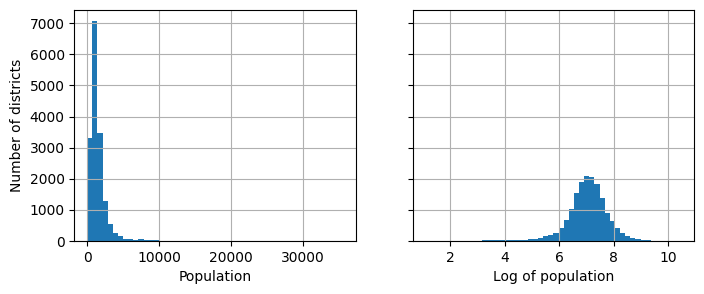

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
plt.show()

Up until now, we have primarily focused on transforming the input features. However, it's important to note that the target values might also require transformation. In certain cases, when the target distribution exhibits a heavy tail, it can be beneficial to replace the target values with their logarithm. This transformation helps mitigate the impact of extreme values in the target distribution.

## Transformation Piplines
As illustrated, there are multiple data transformation steps that must be executed in the correct order. Fortunately, Scikit-Learn offers the Pipeline class to assist with organizing these sequences of transformations. Here is an example of a simple pipeline designed for numerical attributes. It performs imputation and scaling operations on the input features in that specific order.

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"), #data cleaning
    # you may add log transformation if needed
    StandardScaler() #feature scaling
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"), #data cleaning (mode)
    OneHotEncoder(handle_unknown="ignore") #feature encoding
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['ocean_proximity'])])

In [27]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared

array([[ 1.17326778, -1.35034078,  0.42934493, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.2683057 , -1.37845247, -1.4716757 , ...,  0.        ,
         0.        ,  1.        ],
       [-1.35274028,  0.98761451, -0.04591023, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.11784659,  0.30356346, -0.99642054, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18827377, -0.72719839, -0.52116538, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.35294041, -0.66160445, -0.52116538, ...,  0.        ,
         0.        ,  0.        ]])

In [28]:
preprocessing.get_feature_names_out()

array(['num__longitude', 'num__latitude', 'num__housing_median_age',
       'num__total_rooms', 'num__total_bedrooms', 'num__population',
       'num__households', 'num__median_income',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN'], dtype=object)

## End of Preprocessing
Finally! You have defined the problem, obtained the data, conducted exploratory analysis, divided it into training and test sets, and developed a preprocessing pipeline to clean and prepare the data for machine learning algorithms. Now, it's time to choose and train a machine learning model.